# Predicting Australian Credit Card Approval

Several machine learning models are created to predict whether a credit card application will be accepted or denied. According to UCI repository, all attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.

## Importing Libraries and Dataset

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
try:
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

# Assessing performance
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict, GridSearchCV, RepeatedStratifiedKFold

# Classifiers
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

np.random.seed(42) # To make this notebook's output identical at every run

## Inspecting the Dataset

In [3]:
dataset = pd.read_csv(r'credit_card_data/training_data.csv')
dataset.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,20.50,10.00,1,8,4,2.500,1,0,0,0,1,40,1,1
1,1,18.58,5.71,2,2,4,0.540,0,0,0,0,2,120,1,0
2,0,24.75,3.00,2,11,8,1.835,1,1,19,0,2,0,501,1
3,1,27.42,12.50,2,6,5,0.250,0,0,0,1,2,720,1,0
4,1,22.75,11.00,2,11,4,2.500,1,1,7,1,2,100,810,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 15 columns):
A1     255 non-null int64
A2     255 non-null float64
A3     255 non-null float64
A4     255 non-null int64
A5     255 non-null int64
A6     255 non-null int64
A7     255 non-null float64
A8     255 non-null int64
A9     255 non-null int64
A10    255 non-null int64
A11    255 non-null int64
A12    255 non-null int64
A13    255 non-null int64
A14    255 non-null int64
A15    255 non-null int64
dtypes: float64(3), int64(12)
memory usage: 30.0 KB


In [5]:
dataset.describe()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,0.666667,31.583373,5.088196,1.800000,7.450980,4.729412,2.446137,0.552941,0.447059,2.635294,0.462745,1.909804,194.701961,1219.729412,0.462745
std,0.472332,12.114778,5.224500,0.419974,3.738045,1.998355,3.757285,0.498167,0.498167,4.792170,0.499591,0.325585,184.627240,7129.539466,0.499591
min,0.000000,15.750000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,22.670000,1.062500,2.000000,4.000000,4.000000,0.250000,0.000000,0.000000,0.000000,0.000000,2.000000,67.500000,1.000000,0.000000
50%,1.000000,28.750000,3.000000,2.000000,8.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,160.000000,6.000000,0.000000
75%,1.000000,37.585000,8.480000,2.000000,10.000000,5.000000,3.167500,1.000000,1.000000,3.000000,1.000000,2.000000,280.000000,396.000000,1.000000
max,1.000000,80.250000,28.000000,3.000000,14.000000,9.000000,28.500000,1.000000,1.000000,40.000000,1.000000,3.000000,1160.000000,100001.000000,1.000000


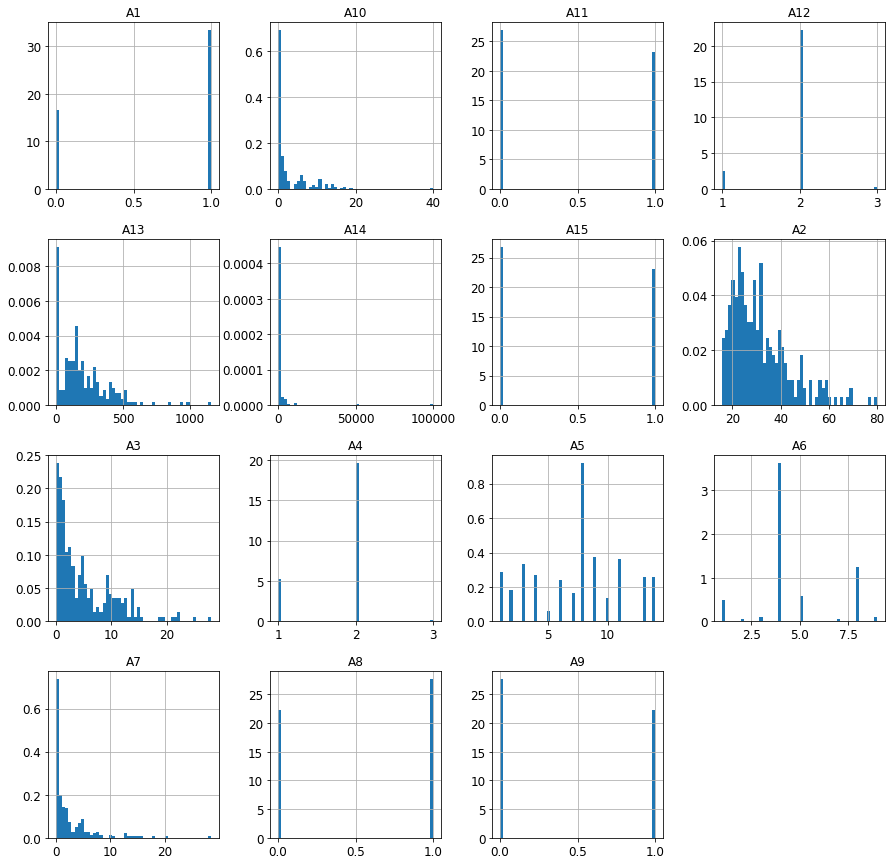

In [6]:
dataset.hist(bins=50,density=True,figsize=(15,15))
plt.show()

## Preprocessing the Data

### Handling Categorical Attributes
Since the size of the dataset is small, One Hot Encoding separately will lead to different shapes in the training and testing data. So, we must OneHotEncode all the categorical variables before we split the dataset into training and testing data.

In [7]:
features = dataset.drop('A15', axis=1)
y_train = dataset['A15'].copy()

In [8]:
cat_attribs = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12'] # get a list of all the categorical attributes
cat_col = features.loc[:, cat_attribs]

encode = OneHotEncoder(categories='auto', sparse=False)
cat_arr = encode.fit_transform(cat_col)
cat_arr

array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [9]:
cat_arr.shape

(255, 35)

Now, we grab all the numerical attributes and concatenate the OneHotEncoded categorical attributes with the numerical attributes.

In [10]:
num_attribs = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14'] # get a list of all the numerical attributes
num_arr = features.loc[:, num_attribs].values
num_arr

array([[2.050e+01, 1.000e+01, 2.500e+00, 0.000e+00, 4.000e+01, 1.000e+00],
       [1.858e+01, 5.710e+00, 5.400e-01, 0.000e+00, 1.200e+02, 1.000e+00],
       [2.475e+01, 3.000e+00, 1.835e+00, 1.900e+01, 0.000e+00, 5.010e+02],
       ...,
       [1.942e+01, 7.250e+00, 4.000e-02, 1.000e+00, 1.000e+02, 2.000e+00],
       [3.358e+01, 2.500e-01, 4.000e+00, 0.000e+00, 4.200e+02, 1.000e+00],
       [4.817e+01, 7.625e+00, 1.550e+01, 1.200e+01, 0.000e+00, 7.910e+02]])

In [11]:
num_arr.shape

(255, 6)

In [12]:
features_std = np.concatenate((num_arr, cat_arr), axis=1)
features_std

array([[2.050e+01, 1.000e+01, 2.500e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.858e+01, 5.710e+00, 5.400e-01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.475e+01, 3.000e+00, 1.835e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.942e+01, 7.250e+00, 4.000e-02, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.358e+01, 2.500e-01, 4.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [4.817e+01, 7.625e+00, 1.550e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [13]:
features_std.shape

(255, 41)

The combined dataset is converted into a dataframe since to make it easier for preprocessing steps.

In [14]:
X_train = pd.DataFrame(data=features_std, 
                       index=[str(i) for i in range(len(features_std))], 
                       columns=[str(i) for i in range(len(features_std[0]))])

X_train

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,20.50,10.000,2.500,0.0,40.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,18.58,5.710,0.540,0.0,120.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,24.75,3.000,1.835,19.0,0.0,501.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,27.42,12.500,0.250,0.0,720.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,22.75,11.000,2.500,7.0,100.0,810.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,35.17,2.500,4.500,7.0,150.0,1271.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
251,23.08,2.500,1.085,11.0,60.0,2185.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
252,19.42,7.250,0.040,1.0,100.0,2.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
253,33.58,0.250,4.000,0.0,420.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [15]:
print(X_train.shape, y_train.shape)

(255, 41) (255,)


## Training Classifiers

In [16]:
num_attribs = [str(i) for i in range(len(num_attribs))]
cat_attribs = [str(i) for i in range(6, len(list(X_train)))]

Define the Repeated Stratified 10-KFold cross validation used for tuning the hyperparameters

In [17]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

Make a pipeline that is responsible for standardizing all numerical attributes, check if any missing value exist in the categorical attributes (this is just done so we return all the categorical attributes), and then applying the classifier. When we pass this pipeline for cross-validation, the 9 KFolds will be standardized seperately from the 10th Kfold which will be used for testing. This makes it so that there is no bias inserted about the distributionn as a whole and our models are as generalized as they can be.

In [18]:
def clf_pipeline(clf):
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean'))])
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_attribs), 
                                                   ('cat', cat_transformer, cat_attribs)])
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', clf)])
    return clf

### Recall and Precision

We will compare the performance of the designed solutions in terms of accuracy, precision, recall, ROC curve, and AUC, and determine the most promising one.

In [19]:
def get_info(clf_pipeline):
    y_score = cross_val_predict(clf_pipeline, X_train, y_train, cv=10, method='predict_proba')

    # hack to work around issue #9589 in Scikit-Learn 0.19.0
    if y_score.ndim == 2:
        y_score = y_score[:, 1]

    false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_score)

    # Plot ROC curves
    plt.subplots(1, figsize=(8.2,5.5))
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # Precision v. Recall    
    P0, R0, T0 = precision_recall_curve(y_train, y_score)
    plt.figure(1, figsize=(18, 12))
    plt.clf()
    plt.subplot(224)
    plt.plot(R0, P0, "b-", linewidth=3)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.show()

    # Report the ROC AUC score
    print('\nROC AUC Score for', clf_pipeline[1].__class__.__name__, ':', roc_auc_score(y_train, y_score), '\n')

### SVM with Hyperparameter Tuning

A Support Vector Machine (SVM) performs classification by finding the hyperplane that maximizes the margin between the two classes. The vectors (cases) that define the hyperplane are the support vectors.	

In [20]:
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

grid = dict(classifier__kernel=kernel, 
            classifier__C=C, 
            classifier__gamma=gamma)

grid_search = GridSearchCV(clf_pipeline(SVC(probability=True)), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__C': 1.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'} with an accuracy of 0.901590


In [21]:
svm_clf = grid_search.best_estimator_

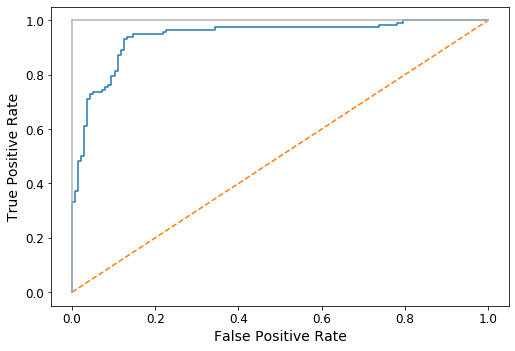

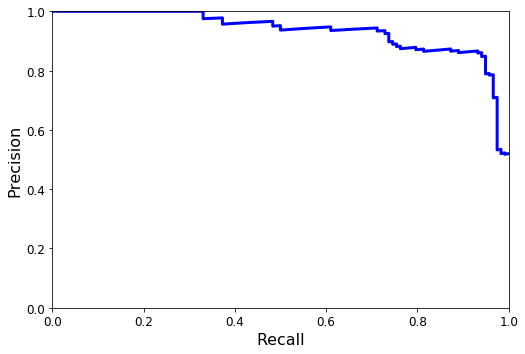


ROC AUC Score for SVC : 0.9402449585549919 



In [22]:
get_info(svm_clf)

### Random Forest Classifier with Hyperparameter Tuning

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes or mean prediction of the individual trees.

In [23]:
n_estimators = [10, 100, 500, 1000]
max_features = ['sqrt', 'log2']

grid = dict(classifier__n_estimators=n_estimators, 
            classifier__max_features=max_features)

grid_search = GridSearchCV(clf_pipeline(RandomForestClassifier()), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__max_features': 'sqrt', 'classifier__n_estimators': 500} with an accuracy of 0.883282


In [24]:
rnd_clf = grid_search.best_estimator_

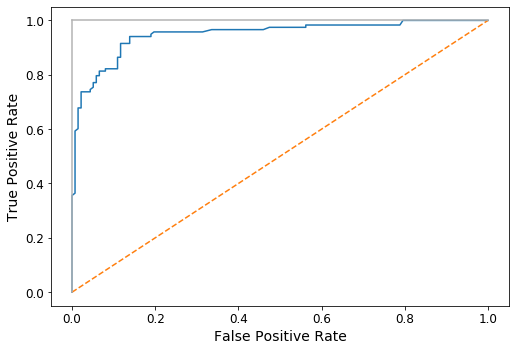

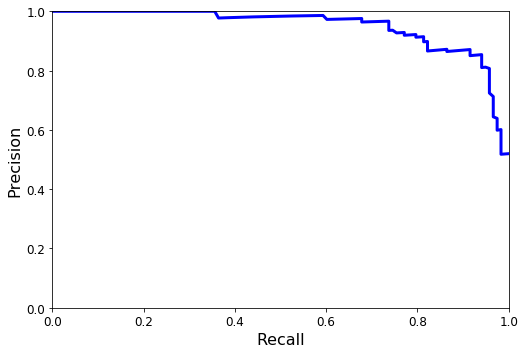


ROC AUC Score for RandomForestClassifier : 0.9486267474947421 



In [25]:
get_info(rnd_clf)

### Logistic Regression with Hyperparameter Tuning

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

In [26]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(classifier__solver=solvers, 
            classifier__penalty=penalty, 
            classifier__C=c_values)

grid_search = GridSearchCV(clf_pipeline(LogisticRegression()), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'} with an accuracy of 0.887487


In [27]:
log_clf = grid_search.best_estimator_

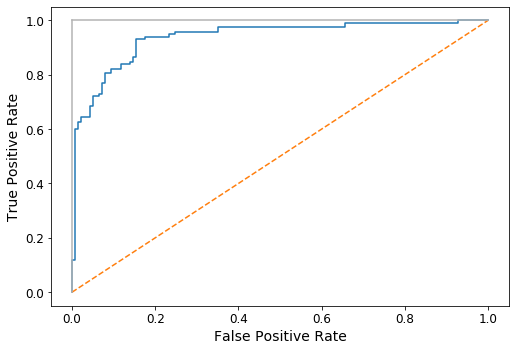

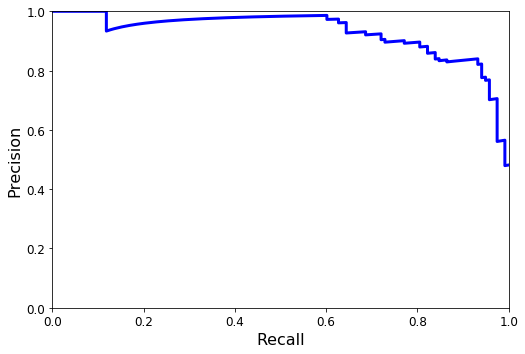


ROC AUC Score for LogisticRegression : 0.9376469132747743 



In [28]:
get_info(log_clf)

### K-Nearest Neighbors (KNN) with Hyperparameter Tuning

In pattern recognition, the k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space.

In [29]:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

grid = dict(classifier__n_neighbors=n_neighbors, classifier__weights=weights, classifier__metric=metric)

grid_search = GridSearchCV(clf_pipeline(KNeighborsClassifier()), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'uniform'} with an accuracy of 0.884667


In [30]:
knn_clf = grid_search.best_estimator_

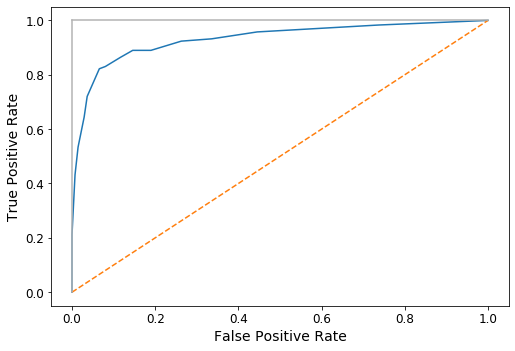

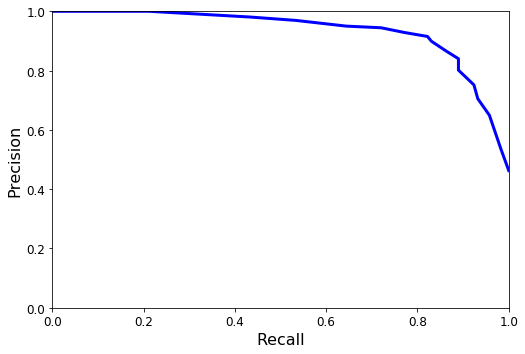


ROC AUC Score for KNeighborsClassifier : 0.9307806507484845 



In [31]:
get_info(knn_clf)

### Stochastic Gradient Boosting with Hyperparameter Tuning

Stochastic gradient descent (often abbreviated SGD) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data).

In [32]:
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

grid = dict(classifier__learning_rate=learning_rate, classifier__n_estimators=n_estimators, classifier__subsample=subsample, classifier__max_depth=max_depth)

grid_search = GridSearchCV(clf_pipeline(GradientBoostingClassifier()), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.5} with an accuracy of 0.892821


In [33]:
grad_clf = grid_search.best_estimator_

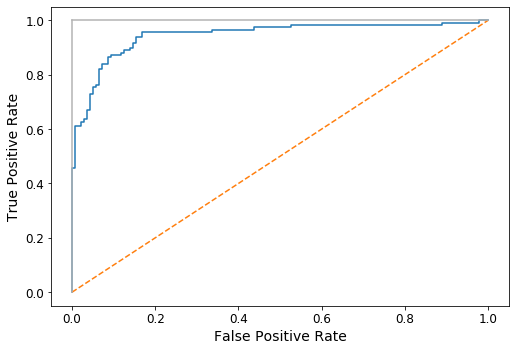

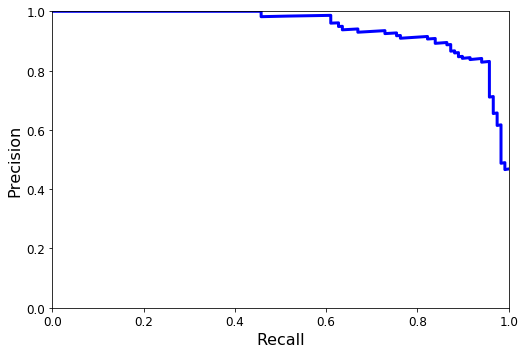


ROC AUC Score for GradientBoostingClassifier : 0.9451936162315971 



In [34]:
get_info(grad_clf)

### Decision Tree Classifier with Bagging and Hyperparameter Tuning

Bagging (Bootstrap Aggregation) is used when our goal is to reduce the variance of a decision tree. Here idea is to create several subsets of data from training sample chosen randomly with replacement. Now, each collection of subset data is used to train their decision trees.

In [35]:
grid = {'classifier__base_estimator__max_depth' : [1, 2, 3, 4, 5],
        'classifier__base_estimator__criterion' : ['gini', 'entropy'],
        'classifier__base_estimator__splitter' :   ['best', 'random'],
        'classifier__n_estimators' : [10, 100, 500, 1000],
        'classifier__max_samples' : [0.1, 0.2, 0.5, 0.7]}

grid_search = GridSearchCV(clf_pipeline(BaggingClassifier(DecisionTreeClassifier())), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 4, 'classifier__base_estimator__splitter': 'random', 'classifier__max_samples': 0.2, 'classifier__n_estimators': 1000} with an accuracy of 0.893846


In [36]:
bag_clf = grid_search.best_estimator_

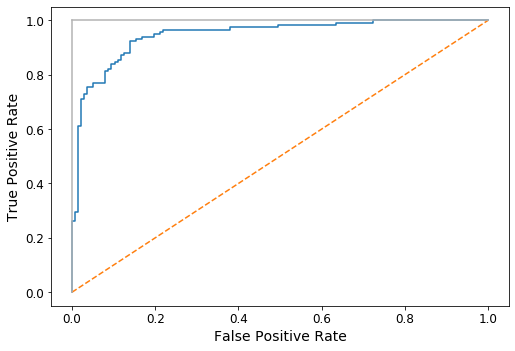

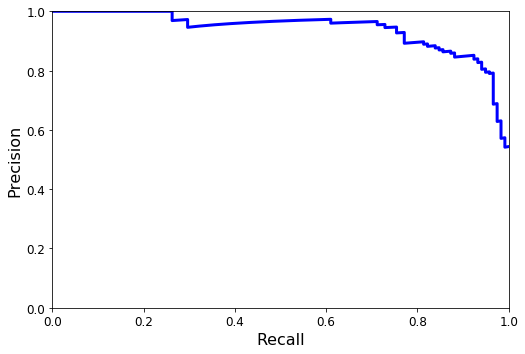


ROC AUC Score for BaggingClassifier : 0.9472349375231969 



In [51]:
get_info(bag_clf)

### Decision Tree Classifier with Boosting and Hyperparameter Tuning

Boosting means that each tree is dependent on prior trees. The algorithm learns by fitting the residual of the trees that preceded it. Thus, boosting in a decision tree ensemble tends to improve accuracy with some small risk of less coverage.

In [37]:
grid = {'classifier__base_estimator__max_depth' : [1, 2, 3, 4, 5],
        'classifier__base_estimator__criterion' : ['gini', 'entropy'],
        'classifier__base_estimator__splitter' :   ['best', 'random'],
        'classifier__algorithm' : ['SAMME', 'SAMME.R'],
        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.5, 0.75],
        'classifier__n_estimators' : [10, 100, 500, 1000]}

grid_search = GridSearchCV(clf_pipeline(AdaBoostClassifier(DecisionTreeClassifier())), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__algorithm': 'SAMME.R', 'classifier__base_estimator__criterion': 'entropy', 'classifier__base_estimator__max_depth': 5, 'classifier__base_estimator__splitter': 'best', 'classifier__learning_rate': 0.75, 'classifier__n_estimators': 1000} with an accuracy of 0.896359


In [38]:
boost_clf = grid_search.best_estimator_

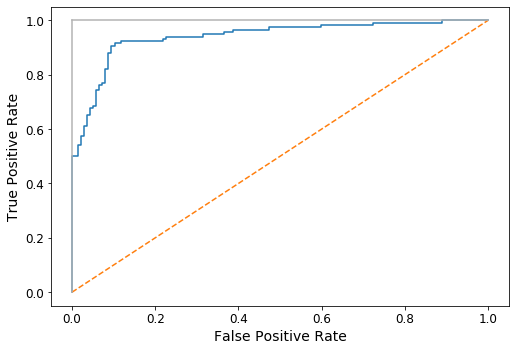

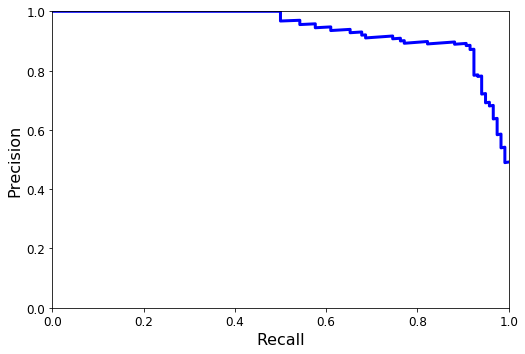


ROC AUC Score for AdaBoostClassifier : 0.940244958554992 



In [52]:
get_info(boost_clf)

### Soft-voting Classifier with Hyperparameter Tuning
Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

In [39]:
classifiers = [('svm', svm_clf[1]),
               ('rnd', rnd_clf[1]),
               ('log', log_clf[1]),
               ('knn', knn_clf[1]),
               ('grad', grad_clf[1]),
               ('bag', bag_clf[1]),
               ('boost', boost_clf[1])]

In [40]:
def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]

In [41]:
grid = dict(classifier__weights=combinations_on_off(len(classifiers)))

grid_search = GridSearchCV(clf_pipeline(VotingClassifier(classifiers, voting="soft")), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Parameters: %s with an accuracy of %f" % (grid_search.best_params_, grid_search.best_score_))

Parameters: {'classifier__weights': [1, 0, 0, 1, 0, 0, 1]} with an accuracy of 0.906821


In [42]:
vot_clf = grid_search.best_estimator_

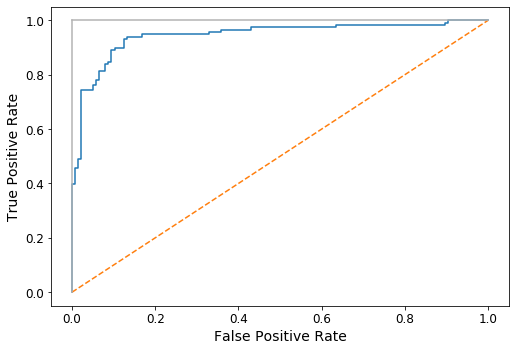

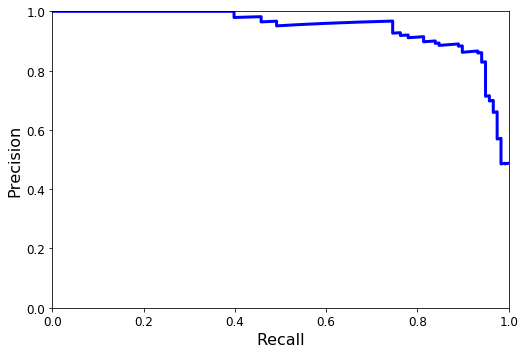


ROC AUC Score for VotingClassifier : 0.9448843251268093 



In [43]:
get_info(vot_clf)

## Applying Best Model on Test Data

ROC is a probability curve and AUC represents degree or measure of separability. It tells how much our model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.

Even though the highest ROC AUC score is that of Random Forest, this project was catered around securing the highest accuracy so we tuned the hyperparameters accordingly.

The highest accraucy rate was achieved by combining our classifiers and getting an ensemble that gave the best results.

In [44]:
test_features = pd.read_csv(r'credit_card_data/test_features.csv').drop('Unnamed: 0', axis=1)

test_features.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1,58.58,2.710,2,8,4,2.415,0,0,0,1,2,320,1
1,1,43.25,25.210,2,11,8,0.210,1,1,1,0,2,760,91
2,1,19.67,10.000,1,4,8,0.835,1,0,0,1,2,140,1
3,1,51.83,2.040,1,1,1,1.500,0,0,0,0,2,120,2
4,0,25.17,2.875,2,14,8,0.875,1,0,0,0,2,360,1


In [45]:
test_features.shape

(207, 14)

### Preprocess the Testing Data

In [46]:
cat_attribs = ['A1', 'A4', 'A5', 'A6', 'A8', 'A9', 'A11', 'A12'] # get a list of all the categorical attributes
cat_col = test_features.loc[:, cat_attribs]

encode = OneHotEncoder(categories='auto', sparse=False)
cat_arr = encode.fit_transform(cat_col)
cat_arr

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [47]:
num_attribs = ['A2', 'A3', 'A7', 'A10', 'A13', 'A14'] # get a list of all the numerical attributes
num_arr = test_features.loc[:, num_attribs]

scale = StandardScaler()
num_arr = scale.fit_transform(num_arr)
num_arr

array([[ 2.33752599, -0.36646686,  0.18714028, -0.54781098,  0.6461304 ,
        -0.26809269],
       [ 1.02593414,  4.10973199, -0.62396383, -0.25853324,  2.93368217,
        -0.24072085],
       [-0.9915046 ,  1.08382157, -0.39405904, -0.54781098, -0.28968623,
        -0.26809269],
       ...,
       [ 0.19859603, -0.35850917,  0.86214076,  1.18785543,  0.04304857,
        -0.26809269],
       [-0.34298104, -0.84790691, -0.65523089, -0.25853324,  0.3965793 ,
        -0.23524648],
       [-0.30020244, -0.64896474, -0.60924993, -0.54781098, -0.28968623,
        -0.26809269]])

In [48]:
features_std = np.concatenate((num_arr, cat_arr), axis=1)
features_std

array([[ 2.33752599, -0.36646686,  0.18714028, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.02593414,  4.10973199, -0.62396383, ...,  0.        ,
         1.        ,  0.        ],
       [-0.9915046 ,  1.08382157, -0.39405904, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.19859603, -0.35850917,  0.86214076, ...,  0.        ,
         1.        ,  0.        ],
       [-0.34298104, -0.84790691, -0.65523089, ...,  0.        ,
         1.        ,  0.        ],
       [-0.30020244, -0.64896474, -0.60924993, ...,  1.        ,
         0.        ,  0.        ]])

In [49]:
features_std.shape

(207, 41)

In [50]:
X_test = pd.DataFrame(data=features_std, 
                      index=[str(i) for i in range(len(features_std))], 
                      columns=[str(i) for i in range(len(features_std[0]))])

X_test

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.337526,-0.366467,0.187140,-0.547811,0.646130,-0.268093,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.025934,4.109732,-0.623964,-0.258533,2.933682,-0.240721,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2,-0.991505,1.083822,-0.394059,-0.547811,-0.289686,-0.268093,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.760015,-0.499758,-0.149440,-0.547811,-0.393666,-0.267789,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.520940,-0.333641,-0.379345,-0.547811,0.854090,-0.268093,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,-0.129088,-0.773304,-0.609250,-0.547811,0.542151,-0.268093,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
203,0.669161,0.288053,-0.226688,0.898578,-0.456054,0.065540,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
204,0.198596,-0.358509,0.862141,1.187855,0.043049,-0.268093,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
205,-0.342981,-0.847907,-0.655231,-0.258533,0.396579,-0.235246,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Final Output

In [53]:
y_pred = vot_clf[1].predict(X_test)
y_pred

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0], dtype=int64)

In [54]:
labels = np.array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
                   1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
                   1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
                   1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
                   1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
                   0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
                   1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
                   0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
                   0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
                   0, 1, 0, 1, 0, 1, 1, 0, 0])

num = np.array([i for i in range(1, len(labels)+1)])

In [57]:
result = pd.DataFrame({"num": num, "label": labels})

result

,num,label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,1
...,...,...
202,203,0
203,204,1
204,205,1
205,206,0


In [58]:
result.to_csv("test_labels.csv", index=False)